# Rock-Paper-Scissors game

### Preprocesamiento y carga de datos

Comenzaremos dandole los permisos necesarios para que Google Colab puede acceder a Google Drive. Seguidamente, generaremos las rutas pertenecientes a nuestros archivos que se encuentran en el propio Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Una vez montado y conectado nuestro notebook y dado los permisos necesarios para acceder a nuestra Unidad de Drive, generaremos las rutas sobre las que trabajaremos.

In [3]:
dataset_path = "/content/drive/MyDrive/Tarea_final/Dataset"

A continuación, debido al tamaño de nuestro dataset, debemos dividrlo por lotes, puesto que sino sería muy pesado en memoría. Para ello haremos uso de la función *Sequence* de Keras que nos ayudará a controlar la carga de los datos y mejorar el procesamiento de los mismos.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2
import os

class RPSSequence(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(200, 300)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        nLotes = int(np.ceil(len(self.image_paths) / self.batch_size))
        print("El número de lotes es de: ", nLotes)
        return nLotes

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        batch_images = []
        for path in batch_paths:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0
            batch_images.append(img)

        return np.array(batch_images), np.array(batch_labels)


Como podemos observar, hemos creado una clase, típica, para manejar la inyección de datos. En un primer lugar hemos definido las propiedades de la clase en el método init. Seguidamente, en el método len estudiamos el número de lotes en los que los dividiremos. Por último, la función getitem da al conjunto de entreamiento un lote cada vez que lo requiera el modelo.

A continuación viene el apartado del preprocesamiento. Sin embargo, en nuestra funcióna anterior ya hemos avanzado en este tema con dos pasos.  El primero de ellos ha sido el escalar las imagenes al realizar:
```
img = img / 255.0  
```

Con esto pretendemos es acotar el rango ya que como va de [0,255] relentizaría bastante el preprocesamiento, por lo que ahora se movería en un rango de [0,1].

Otra acción ha sido la redimensión de las imagenes ya que todos los modelos de DL necesitan de que todas las imagenes reciban el mismo tamaño. Para ello hemos hecho uso de la función:
```
img = cv2.resize(img, self.target_size)
```

Gracias a estas dos acciones conseguimos uniformidad en el tamaño de las imagenes y normalización.

Ahora, podemos dividir el conjunto de datos que lo separaremos en: train (70%), val (20%) y test (10%).

In [5]:
import glob
from sklearn.model_selection import train_test_split

clases = {"rock": 0, "paper": 1, "scissors": 2}

image_paths = []
labels = []

for clase, idx in clases.items():
    paths = glob.glob(os.path.join(dataset_path, clase, "*.png"))
    image_paths.extend(paths)
    labels.extend([idx] * len(paths))

image_paths = np.array(image_paths)
labels = np.array(labels)


X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

print(f"Para el conjunto train (70%) contamos con: {len(X_train)} imagenes.")
print(f"Para el conjunto val (20%) contamos con: {len(X_val)} imagenes.")
print(f"Para el conjunto test (10%) contamos con: {len(X_test)} imagenes.")

Para el conjunto train (70%) contamos con: 1558 imagenes.
Para el conjunto val (20%) contamos con: 448 imagenes.
Para el conjunto test (10%) contamos con: 221 imagenes.


Una vez dividos los conjuntos haremos uso de la función previamente creada, *class RPSSequence*, para dividir los datos en los lotes anteriomente explicado. En este caso utilizaremos un batch_size de 32 ya que nos aporta menos memoria RAM, nos ayuda a generalizar y es más ruidoso.

In [6]:
batch_size = 32

train_gen = RPSSequence(X_train, y_train, batch_size=batch_size)
val_gen = RPSSequence(X_val, y_val, batch_size=batch_size)
test_gen = RPSSequence(X_test, y_test, batch_size=batch_size)

### Entrenamiento de modelos

En esta nueva sección generaremos distintos modelos de DL, con el fin de aproximarnos a aquel que nos arroje los mejores resultados.

Crearemos una red nueronal convolucional (CNN), que son las especializadas en el preprocesamiento de imagenes, a partir de la detección de bordes, texturas...

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(200,300,3)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Comenzaremos a desgranar este modelo. En primer lugar le atribuimos kernel de 32 don el fin de detectar patrones. A mayor valor, más aprendizaje pero mayor riesgo de overfitting. Por otro lado, tenemos un tamaño de filto de 3 de alto y ancho, esto es el area de la imagen que observará. Seguidamente hemos propuesto como función de activación la relu y una dimensión de entrada de 200x300px y 3 canales rgb.

A continuación en MaxPooling2D reducimos las caracteristicas de la imagen a la mitad, por el (2,2) para su capturación.

Por último, declaramos que la red debe tener 128 neuronas y tendrá una salida de 3 grupos, por scissors, paper y rock.

Una vez generada esta primera red neuronal, marcamos la función perdida, el optimizador y la métrica.

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    batch_size=32
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


El número de lotes es de:  49
El número de lotes es de:  49
El número de lotes es de:  49
Epoch 1/5
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4165 - loss: 17.6041El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
49/49 ━━━━━━━━━━━━━━━━━━━━ 414s 8s/step - accuracy: 0.4185 - loss: 17.4084 - val_accuracy: 0.7924 - val_loss: 0.5884
Epoch 2/5
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8391 - loss: 0.4502El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 356ms/step - accuracy: 0.8395 - loss: 0.4495 - val_accuracy: 0.8772 - val_loss: 0.4222
Epoch 3/5
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8974 - loss: 0.3038El nú

Para observar los resultados más correctamente los visualizaremos en la siguiente tabla, y a continuación discutiremos los resultados.

| Época | Accuracy (train) | Loss (train) | Accuracy (val) | Loss (val) |
| ----- | ---------------- | ------------ | -------------- | ---------- |
| 1     | 41.65 %          | 17.6041      | 79.24 %        | 0.5884     |
| 2     | 83.95 %          | 0.4495       | 87.72 %        | 0.4222     |
| 3     | 89.78 %          | 0.3033       | 87.50 %        | 0.4024     |
| 4     | 92.81 %          | 0.2142       | 90.18 %        | 0.3429     |
| 5     | 94.80 %          | 0.1699       | 89.06 %        | 0.3351     |

En la primera época observamos un mal accuracy y una función perdida alta. Esto es esperable al estar iniciandose.

De la segunda a la última época observamos como el accuracy mejora progresivamete, al igual que la función de perdida se aminora. Sin embargo, el accierto en val en la última época disminuye y la función perdida supera a la de la epoca 3. Es por ello que podemos entender que el modelo tiende a sobreajuste, por lo que el modelo empieza a memorizar demasiado el train.

A continuación realizaremos un ajuste de hiperparametros. Para ello utilizaremos la herramienta **Keras Tuner** la cual sirve para probar combinaciones automáticamente.

In [10]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [11]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(hp):
    model = Sequential()

    model.add(Conv2D(
        filters=hp.Choice("conv_filters", values=[32, 64, 128]),
        kernel_size=hp.Choice("kernel_size", values=[3,5]),
        activation=hp.Choice("conv_activation", ["relu", "tanh", "sigmoid"]),
        input_shape=(200,300,3)
    ))
    model.add(MaxPooling2D((2,2)))

    if hp.Boolean("use_dropout"):
        model.add(Dropout(rate=0.3))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice("dense_units", values=[64, 128, 256]),
        activation='relu'
    ))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=hp.Choice("optimizer", values=["adam", "sgd", "rmsprop"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    directory="tuner_results",
    project_name="rps"
)

tuner.search(train_gen, validation_data=val_gen, epochs=5)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 02m 23s]
val_accuracy: 0.640625

Best val_accuracy So Far: 0.9084821343421936
Total elapsed time: 00h 11m 55s


Como podemos observar, el accurcy que capta es del 87%, por lo que es bastante bueno. Ahora veremos cuales son de la función perdida de train, así como en val.

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

train_loss, train_acc = best_model.evaluate(train_gen, verbose=0)
val_loss, val_acc = best_model.evaluate(val_gen, verbose=0)

El número de lotes es de:  49
El número de lotes es de:  49
El número de lotes es de:  49
Epoch 1/5
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9426 - loss: 0.2012El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.9425 - loss: 0.2011 - val_accuracy: 0.9129 - val_loss: 0.2644
Epoch 2/5
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9604 - loss: 0.1458El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step - accuracy: 0.9603 - loss: 0.1459 - val_accuracy: 0.8951 - val_loss: 0.2976
Epoch 3/5
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9532 - loss: 0.1401El

El resultado, ya con los hiperparametros ajustados es:

| Época | Accuracy (train) | Loss (train) | Accuracy (val) | Loss (val) |
| ----- | ---------------- | ------------ | -------------- | ---------- |
| 1     | 94.25 %          | 0.2011       | 91.29 %        | 0.2644     |
| 2     | 96.03 %          | 0.1459       | 89.51 %        | 0.2976     |
| 3     | 95.34 %          | 0.1399       | 94.20 %        | 0.2076     |
| 4     | 97.22 %          | 0.0969       | 91.74 %        | 0.2808     |
| 5     | 96.88 %          | 0.1008       | 93.75 %        | 0.2078     |


Aqui podemos observar que hasta el tercer epoch sube linealmente, para en el cuarto descender levemente y en el quinto y último epochs tener el máximo de trains accuracy. A su vez la función perdidia en train es al más baja. De la misma forma, respecto a val, obtenemos uno de los mejores resultados y aunque no sea la mejor funcion perdida, es igualmente uno de los mejores resultados.

A continuación observaremos cuales son los mejores hiperparametros que nos marca Keras Turner.

In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for param, value in best_hps.values.items():
    print(f"{param}: {value}")

conv_filters: 64
kernel_size: 3
conv_activation: tanh
use_dropout: True
dense_units: 64
optimizer: sgd


Los parámetros que hemos ajustado que componen esta última red neuronal son. En la parte convolucional, cambiamos a 64 filtros y una kernel de 3x3. Sin embargo, la función de activación es la tangente. En la regularización este modelo ha optado por usar el dropout. Por último, mencionaremos el optimizador que ha pasado de ser adams a sgd, puesto que tiende a ir mejor en problemas de imágenes y secuencias.

A continuación, realizaremos técnicas de regularización Lasso, que penaliza los coeficientes absolutos, y Ridge, que se encarga de el cuadrado de los coeficientes. Los evaluaremos independientes con el fin de obtener el mejor resultado.

In [14]:
from tensorflow.keras import models, layers, optimizers, regularizers

def build_model(reg_type=None, l1_val=1e-5, l2_val=1e-4):
    if reg_type == "l1":
        reg = regularizers.l1(l1_val)
    elif reg_type == "l2":
        reg = regularizers.l2(l2_val)
    elif reg_type == "l1_l2":
        reg = regularizers.l1_l2(l1=l1_val, l2=l2_val)
    else:
        reg = None

    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='tanh', input_shape=(200,300,3),
                      kernel_regularizer=reg),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='tanh', kernel_regularizer=reg),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
    optimizer=optimizers.RMSprop(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

    return model

model_original = build_model(reg_type=None)
model_l1       = build_model(reg_type="l1")
model_l2       = build_model(reg_type="l2")
model_l1_l2    = build_model(reg_type="l1_l2")

history_original = model_original.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

history_l1 = model_l1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

history_l2 = model_l2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

history_l1_l2 = model_l1_l2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

results = {
    "Original": model_original.evaluate(test_gen, verbose=0),
    "L1": model_l1.evaluate(test_gen, verbose=0),
    "L2": model_l2.evaluate(test_gen, verbose=0),
    "L1+L2": model_l1_l2.evaluate(test_gen, verbose=0)
}

for name, (loss, acc) in results.items():
    print(f"{name} -> Loss: {loss:.4f}, Accuracy: {acc:.4f}")

El número de lotes es de:  49
El número de lotes es de:  49
El número de lotes es de:  49
Epoch 1/20
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.3230 - loss: 4.1083El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.3231 - loss: 4.0966 - val_accuracy: 0.3549 - val_loss: 1.6856
Epoch 2/20
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.3525 - loss: 1.3195El número de lotes es de:  14
El número de lotes es de:  14
El número de lotes es de:  14
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.3524 - loss: 1.3168 - val_accuracy: 0.3259 - val_loss: 1.0992
Epoch 3/20
El número de lotes es de:  49
El número de lotes es de:  49
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3402 - loss: 1.108

Elegir una regularización correcta, es crucial, en este casó la mejor opción es utilizar las dos opciones. Aún así, detacamos que la regularización *Lasso* es la que más aporta, por lo que podemos destacar que nuestro dataset se se beneficiaba más de la selección de características que de reducir magnitudes de pesos.

A continuación, pasaremos expandir los datos de forma artificial con el fin de que generealice mejor. De esta forma, en cada batch se generen imágenes ligeramente modificadas, por lo que el modelo nunca ve dos veces exactamente el mismo dato. Previamente, deberemos convertir los arrays de nuestras imagenes, es decir, las direcciones, por arrays de imagenes, tipo float32.

In [19]:
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def load_images(file_paths, target_size=(128,192)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images, dtype="float32")

X_train_arr = load_images(X_train)
X_val_arr   = load_images(X_val)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,192,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    datagen.flow(X_train_arr, y_train, batch_size=8),
    validation_data=(X_val_arr, y_val),
    epochs=20
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.4518 - loss: 2.1686 - val_accuracy: 0.4286 - val_loss: 0.9373
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6890 - loss: 0.7594 - val_accuracy: 0.6853 - val_loss: 0.6675
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7637 - loss: 0.6083 - val_accuracy: 0.9040 - val_loss: 0.3431
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8261 - loss: 0.4840 - val_accuracy: 0.7835 - val_loss: 0.5119
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8064 - loss: 0.5319 - val_accuracy: 0.9241 - val_loss: 0.2561
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8705 - loss: 0.3421 - val_accuracy: 0.9286 - val_loss: 0.2222
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8789 - loss: 0.3039 - val_accuracy: 0.9487 - val_loss: 0.1844
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9040 - loss: 0.2772 - va

Por último, aplicaremos las técnica de transferencia del conocimiento que a traves de modelos ya preentrenados, es decir que no parten de 0, se entrena con ciertos modelos ya que saben reconocer bordes, texturas... Previamente, deberemos redimiensarional ya que funciona MobileNetV2 con iamgenes cuadradas.

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, optimizers


X_train_arr = load_images(X_train, target_size=(160,160))
X_val_arr   = load_images(X_val, target_size=(160,160))

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160,160,3))
base_model.trainable = False

transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

transfer_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_tl = transfer_model.fit(
    datagen.flow(X_train_arr, y_train, batch_size=10),
    validation_data=(X_val_arr, y_val),
    epochs=10
)

val_loss, val_acc = transfer_model.evaluate(X_val_arr, y_val, verbose=0)
print(f"Transfer Learning -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.7987 - loss: 0.5079 - val_accuracy: 0.9777 - val_loss: 0.0579
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9728 - loss: 0.1019 - val_accuracy: 0.9911 - val_loss: 0.0244
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9872 - loss: 0.0346 - val_accuracy: 0.9888 - val_loss: 0.0313
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9913 - loss: 0.0344 - val_accuracy: 0.9911 - val_loss: 0.0241
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9928 - loss: 0.0279 - val_accuracy: 0.9933 - val_loss: 0.0227
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9906 - loss: 0.0333 - val_accuracy: 0.9955 - val_loss: 0.0335
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9854 - loss: 0.0413 - val_accuracy: 0.9978 - val_loss: 0.0212
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 

Nuestro modelo pareece ser bueno, puesto que ha llegado a una predicción de 99%. Previamente, con CNN llegaba a 93%. Sin embargo, ahora tras aplicarle transfer learning hemos conseguido mejorarlo.


Una vez desarrollados todos los modelos, los compararemos.

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
              precision    recall  f1-score   support

        Rock       0.99      1.00      1.00       146
       Paper       1.00      0.99      1.00       143
    Scissors       1.00      1.00      1.00       159

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



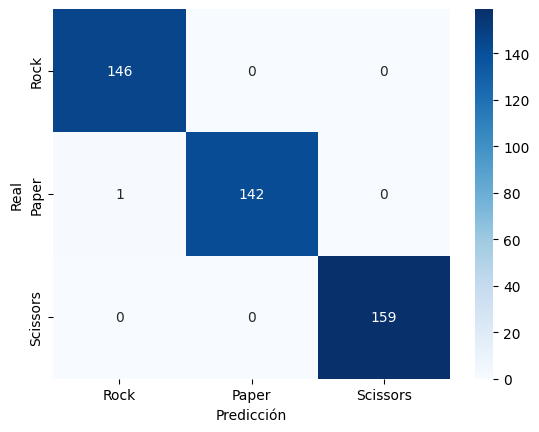

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.argmax(transfer_model.predict(X_val_arr), axis=1)

print(classification_report(y_val, y_pred, target_names=["Rock","Paper","Scissors"]))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Rock","Paper","Scissors"], yticklabels=["Rock","Paper","Scissors"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
